In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pathlib import Path


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import category_encoders as ce

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE,RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier


from scipy.stats import uniform, randint
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score

# Import delle librerie essenziali
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


import os
import copy
import time
import random

from itertools import product


df = pd.read_csv("EdgeIIoT-dataset.csv")

print(f"Dimensioni del dataset: {df.shape}")

print(df.isnull().sum().sort_values())

threshold = 0.95

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

frac_zeros = (df[numeric_cols] == 0).sum() / len(df)

cols_to_drop = frac_zeros[frac_zeros > threshold].index.tolist()

print("Colonne numeriche con troppi zeri da droppare:")
print(cols_to_drop)
df = df.drop(columns=cols_to_drop)
print("\nShape dopo drop:", df.shape)


df.dtypes.to_csv("../tipi_di_dati_2.csv", header=["dtype"])


numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

categorical_features = df.select_dtypes(include=['object','str']).columns.tolist()


print("Feature numeriche:", numeric_features)
print("Feature categoriche:", categorical_features)

onehot_features = ['arp.dst.proto_ipv4', 'arp.src.proto_ipv4',
                   'http.request.method', 'http.request.version',
                   'mqtt.conack.flags', 'mqtt.protoname']

labelencode_features = ['ip.src_host', 'ip.dst_host', 'tcp.srcport', 'mqtt.topic','frame.time','dns.qry.name.len']

binary_features = ['http.file_data', 'http.request.uri.query', 'http.referer',
                   'http.request.full_uri', 'tcp.options', 'tcp.payload', 'mqtt.msg']

be = ce.BinaryEncoder(cols=binary_features, return_df=True)
df = be.fit_transform(df)

target_feature = 'Attack_type'
le_target = LabelEncoder()
df[target_feature] = le_target.fit_transform(df[target_feature])

for col in labelencode_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

df_enc = pd.get_dummies(df, columns=onehot_features, dummy_na=False)

print("Shape finale:", df_enc.shape)

y = df_enc['Attack_type']
X = df_enc.drop(columns="Attack_type")






X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42)

# STEP 2: Separa train (60%) e validation (20%) dal rimanente 80%
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.25, 
    random_state=42, 
    stratify=y_train_val  # 0.25 * 0.8 = 0.2
)





from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
 
# # Supponiamo che X e y siano i tuoi dati sbilanciati
print(f"Distribuzione originale: {Counter(y_train)}")
# 
# # 1. Inizializzazione del campionatore
# # sampling_strategy='auto' pareggia le classi 1:1
rus = RandomUnderSampler(random_state=42, replacement=False)
# #  # 2. Applicazione dell'undersampling
X_train, y_train = rus.fit_resample(X_train, y_train)
 

print(f"Nuova distribuzione: {Counter(y_train)}")



print(df_enc['Attack_type'].value_counts(normalize=True))


scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


C:\Users\andre\AppData\Local\Temp\ipykernel_19220\2553009440.py:39: DtypeWarning: Columns (0: ip.dst_host, 1: arp.dst.proto_ipv4, 2: arp.src.proto_ipv4, 3: http.file_data, 4: http.request.uri.query, 5: http.request.method, 6: http.referer, 7: http.request.full_uri, 8: http.request.version, 9: tcp.options, 10: tcp.payload, 11: tcp.srcport, 12: dns.qry.name.len, 13: mqtt.conack.flags, 14: mqtt.msg, 15: mqtt.protoname, 16: mqtt.topic) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("EdgeIIoT-dataset.csv")


Dimensioni del dataset: (2219201, 63)
frame.time            0
ip.src_host           0
ip.dst_host           0
arp.dst.proto_ipv4    0
arp.opcode            0
                     ..
mbtcp.len             0
mbtcp.trans_id        0
mbtcp.unit_id         0
Attack_label          0
Attack_type           0
Length: 63, dtype: int64
Colonne numeriche con troppi zeri da droppare:
['arp.opcode', 'arp.hw.size', 'icmp.transmit_timestamp', 'icmp.unused', 'http.content_length', 'http.response', 'http.tls_port', 'tcp.connection.synack', 'udp.port', 'udp.time_delta', 'dns.qry.name', 'dns.qry.qu', 'dns.qry.type', 'dns.retransmission', 'dns.retransmit_request', 'dns.retransmit_request_in', 'mqtt.conflag.cleansess', 'mqtt.conflags', 'mqtt.msg_decoded_as', 'mqtt.proto_len', 'mqtt.topic_len', 'mqtt.ver', 'mbtcp.len', 'mbtcp.trans_id', 'mbtcp.unit_id']

Shape dopo drop: (2219201, 38)
Feature numeriche: ['icmp.checksum', 'icmp.seq_le', 'tcp.ack', 'tcp.ack_raw', 'tcp.checksum', 'tcp.connection.fin', 'tcp.conn

# ADA Boost

In [23]:

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


from scipy.stats import uniform, randint
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score


# 3. Parametri AdaBoost
param_grid = {
    'n_estimators': [200, 500, 1000], # Molti più stimatori
    'learning_rate': [0.05, 0.1,0.5], # Rate più basso per compensare n_estimators
    'estimator':[DecisionTreeClassifier(max_depth=3)]

}


ada_search = GridSearchCV(AdaBoostClassifier(random_state=42), param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
ada_search.fit(X_train, y_train)



best_ada = ada_search.best_params_

ada = AdaBoostClassifier(**best_ada, random_state=42)
ada.fit(X_train, y_train)
# Predict continuous values
y_pred_ada = ada.predict(X_test)



best f1_weighted: 0.999782842939758
AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3),
                   learning_rate=0.05, n_estimators=1000, random_state=42)
Accuracy AdaBoost: 0.9996

Classification Report:

                       precision    recall  f1-score   support

             Backdoor       1.00      1.00      1.00      4891
            DDoS_HTTP       1.00      1.00      1.00     10117
            DDoS_ICMP       1.00      1.00      1.00     23171
             DDoS_TCP       1.00      1.00      1.00     10079
             DDoS_UDP       1.00      1.00      1.00     24323
       Fingerprinting       0.98      1.00      0.99       182
                 MITM       1.00      1.00      1.00       263
               Normal       1.00      1.00      1.00    323305
             Password       0.99      1.00      1.00      9971
        Port_Scanning       0.99      1.00      1.00      4514
           Ransomware       1.00      1.00      1.00      2160
        SQL_inj

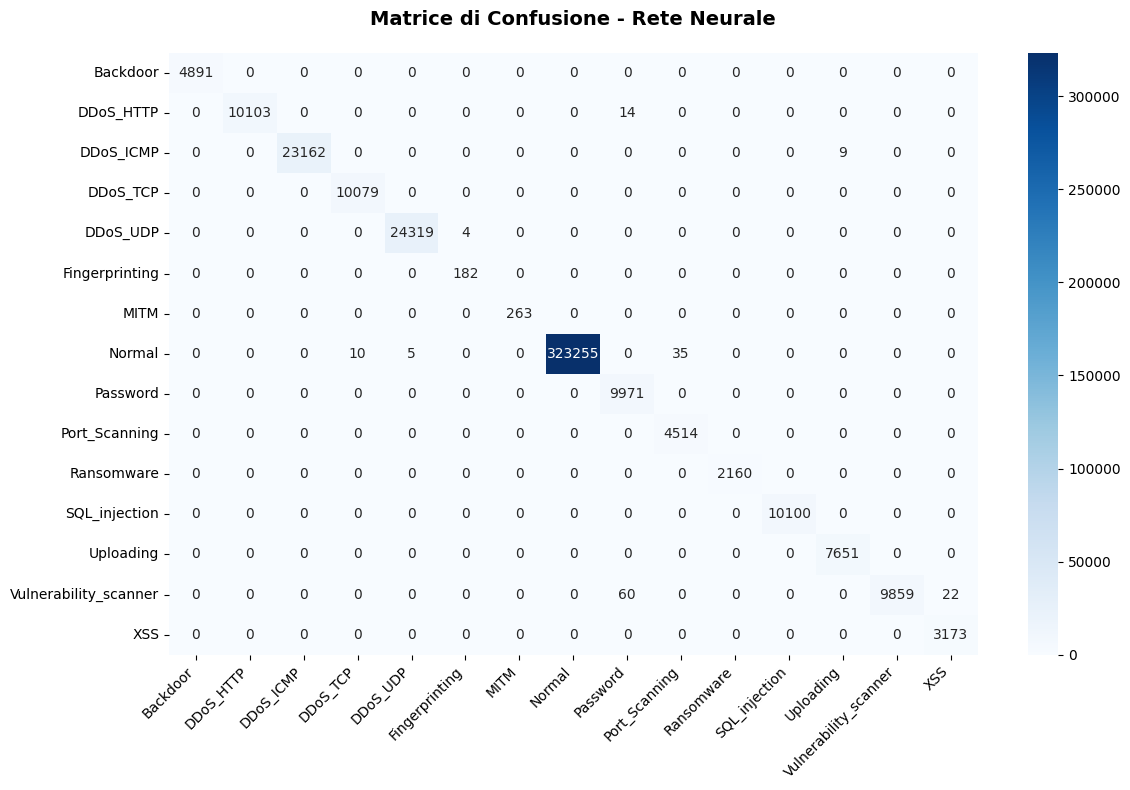

In [25]:
print("best f1_weighted:", ada_search.best_score_)
print(ada_search.best_estimator_)
# Accuracy
acc_ada = accuracy_score(y_test, y_pred_ada)
print(f"Accuracy AdaBoost: {acc_ada:.4f}")

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_ada, target_names=le_target.classes_))

#matrice di confusione
cm_ada = confusion_matrix(y_test, y_pred_ada)

# Use original class names from LabelEncoder
labels = le_target.classes_


plt.figure(figsize=(12, 8))
sns.heatmap(cm_ada, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels,
            yticklabels=labels)
plt.title('Matrice di Confusione - Rete Neurale', 
          fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## RandomForest

In [13]:


# Definizione del modello e dei parametri da testare
rf = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Ricerca della migliore combinazione
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='f1',n_jobs=-1)
grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_
print(f"Migliori parametri RF: {grid_rf.best_params_}")

c:\Users\andre\Documents\visualstudio\git\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1137: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Migliori parametri RF: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}


Accuracy Random Forest: 0.9999

Classification Report:

                       precision    recall  f1-score   support

             Backdoor       1.00      1.00      1.00      4891
            DDoS_HTTP       1.00      1.00      1.00     10117
            DDoS_ICMP       1.00      1.00      1.00     23171
             DDoS_TCP       1.00      1.00      1.00     10079
             DDoS_UDP       1.00      1.00      1.00     24323
       Fingerprinting       1.00      1.00      1.00       182
                 MITM       1.00      1.00      1.00       263
               Normal       1.00      1.00      1.00    323305
             Password       1.00      1.00      1.00      9971
        Port_Scanning       1.00      1.00      1.00      4514
           Ransomware       1.00      1.00      1.00      2160
        SQL_injection       1.00      1.00      1.00     10100
            Uploading       1.00      1.00      1.00      7651
Vulnerability_scanner       1.00      1.00      1.00      994

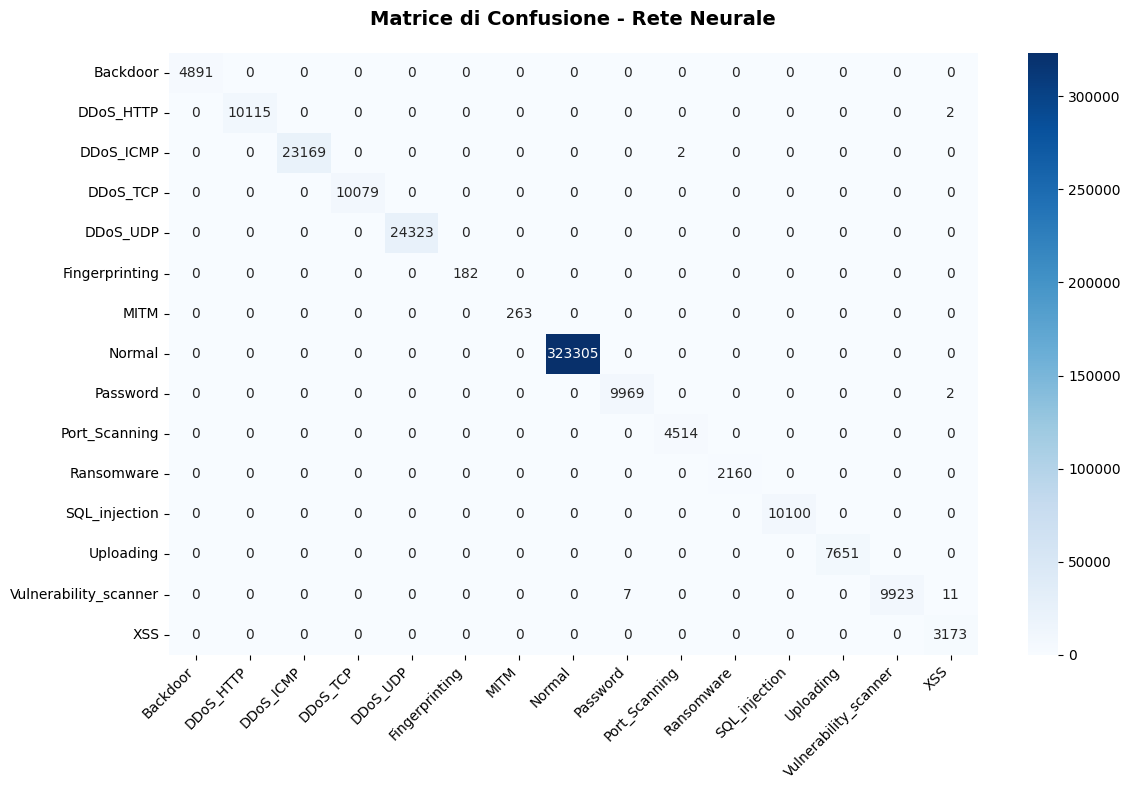

In [14]:

# Predizione e valutazione Random Forest
y_pred_rf = best_rf.predict(X_test)

# Accuracy
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy Random Forest: {acc_rf:.4f}")

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_rf, target_names=le_target.classes_))

# Matrice di confusione
cm_rf = confusion_matrix(y_test, y_pred_rf)
labels = le_target.classes_

plt.figure(figsize=(12, 8))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels,
            yticklabels=labels)
plt.title('Matrice di Confusione - Rete Neurale', 
          fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# Rete Neurale

In [ ]:

# Configurazione
torch.manual_seed(42)
np.random.seed(42)
plt.style.use('default')

print("📦 Librerie caricate con successo!")
print(f"🔥 PyTorch: {torch.__version__}")

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"⚙️ Device: {device}")

# Numero di classi (determinato dal LabelEncoder)
num_classes = len(le_target.classes_)
print(f"🏷️ Numero classi: {num_classes} → {list(le_target.classes_)}")

print("📊 DIVISIONE DATASET:")
print(f"🏋️ Train:      {len(X_train):6d} campioni ({len(X_train)/(len(X_train)+len(X_val)+len(X_test))*100:.1f}%)")
print(f"✅ Validation: {len(X_val):6d} campioni ({len(X_val)/(len(X_train)+len(X_val)+len(X_test))*100:.1f}%)")
print(f"🎯 Test:       {len(X_test):6d} campioni ({len(X_test)/(len(X_train)+len(X_val)+len(X_test))*100:.1f}%)")


# Verifica distribuzione classi
print("\n🔍 Distribuzione classi per set:")
for name, y_set in [("Train", y_train), ("Val", y_val), ("Test", y_test)]:
    dist = [np.sum(y_set == i) for i in range(num_classes)]
    print(f"{name:5}: {dist}")


# Conversione in tensori PyTorch
X_train_tensor = torch.FloatTensor(X_train)
X_val_tensor = torch.FloatTensor(X_val) 
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.LongTensor(np.array(y_train, dtype=np.int64))
y_val_tensor = torch.LongTensor(np.array(y_val, dtype=np.int64))  
y_test_tensor = torch.LongTensor(np.array(y_test, dtype=np.int64))  

print(f"\n🔄 TENSORI PYTORCH:")
print(f"X_train: {X_train_tensor.shape}")
print(f"X_val:   {X_val_tensor.shape}")
print(f"X_test:  {X_test_tensor.shape}")
print(f"Input features: {X_train_tensor.shape[1]}")




def fix_random(seed):
    torch.manual_seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(42)

val_dataloader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=y_val_tensor.shape[0])
test_dataloader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=y_test_tensor.shape[0])

def get_model(input_size, num_classes, dept=3, hidden_size=64, dropout_prob=0.2):

    # 1. Primo layer: Connette l'input al primo strato nascosto
    model = [nn.Linear(input_size, hidden_size), nn.ReLU()]
    
    # 2. Layer intermedi (Hidden): Vengono aggiunti in un ciclo in base a 'dept'
    for i in range(dept):
        model.append(nn.Linear(hidden_size, hidden_size)) # Connessione lineare
        model.append(nn.ReLU())                           # Attivazione non lineare
        model.append(nn.Dropout(dropout_prob))            # Regolarizzazione (Dropout)
        
    # 3. Output layer: Connette l'ultimo layer nascosto alle classi finali
    model.append(nn.Linear(hidden_size, num_classes))
    
    # nn.Sequential unisce la lista di layer in un unico modello ordinato
    return nn.Sequential(*model)


# --- GRID SEARCH SETUP ---
hidden_sizes = [128, 256]          
dropout_probs = [0.2, 0.3]         
depts = [3, 4]                     
batch_sizes = [16, 32]             
learning_rates = [0.001, 0.01]     

params = product(hidden_sizes, dropout_probs, depts, batch_sizes, learning_rates)

# Calcoliamo quante combinazioni dovremo testare
combinations = len(hidden_sizes)*len(dropout_probs)*len(depts)*len(batch_sizes)*len(learning_rates)
print("Numero totale di configurazioni da testare: ", combinations)


def train(model, train_dataloader, val_dataloader, device, hidden_size=64, dropout_prob=0.2, dept=3, epochs=100, batch_size=32, learning_rate=.001):
    """
    Esegue il training di un singolo modello.
    """
    # Spostiamo il modello sul device (GPU/CPU)
    model = model.to(device)
    
    # LOSS FUNCTION: Usiamo CrossEntropyLoss perché è un problema di Classificazione 
    criterion = nn.CrossEntropyLoss()
    
    # OPTIMIZER: Adam è l'algoritmo che aggiorna i pesi per minimizzare l'errore
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Liste per salvare lo storico degli errori
    train_loss = []
    val_loss = []

    # EARLY STOPPING:
    # ferma il modello se smette di migliorare sul validation set.
    best_model = None
    best_loss = np.inf   # Inizializziamo con infinito
    patience = 10        # Quante epoche aspettiamo se non migliora
    patience_counter = 0

    # --- CICLO DI TRAINING (EPOCHE) ---
    for epoch in range(epochs):
        epoch_start = time.time()
        epoch_loss = 0

        # Mettiamo il modello in modalità training (abilita Dropout, ecc.)
        model.train() 

        # Iteriamo sui batch di dati
        for x, y in train_dataloader:
            x, y = x.to(device), y.to(device) 
            
            optimizer.zero_grad()    # 1. Azzeriamo i gradienti precedenti
            y_pred = model(x)        # 2. Forward pass (previsione)
            loss = criterion(y_pred, y) # 3. Calcolo errore
            loss.backward()          # 4. Backward pass (calcolo gradienti)
            optimizer.step()         # 5. Aggiornamento pesi
            
            epoch_loss += loss.item()

        # Salviamo la loss media di training per questa epoca
        train_loss.append(epoch_loss / len(train_dataloader))

        # --- VALIDATION ---
        model.eval() # Modalità valutazione (disabilita Dropout)
        epoch_val_loss = 0
        with torch.no_grad(): # Disabilita calcolo gradienti (più veloce, meno memoria)
            for x, y in val_dataloader:
                x, y = x.to(device), y.to(device)
                y_pred = model(x)
                loss = criterion(y_pred, y)
                epoch_val_loss += loss.item()
        val_loss.append(epoch_val_loss / len(val_dataloader))

        # Stampa progressi ogni 10 epoche
        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Train loss: {train_loss[-1]:.4f}, Val loss: {val_loss[-1]:.4f}, Time: {time.time()-epoch_start:.2f}s')

        # --- EARLY STOPPING CHECK ---
        # Se l'errore di validazione è il più basso visto finora, salviamo questo modello
        if val_loss[-1] < best_loss:
            best_loss = val_loss[-1]
            best_model = copy.deepcopy(model) # Creiamo una copia del modello attuale
            patience_counter = 0 # Resettiamo il contatore
        else:
            # Se non migliora, incrementiamo il contatore
            patience_counter += 1
            if patience_counter == patience:
                # Se abbiamo aspettato troppo interrompiamo.
                print("Early stopping...") 
                break

    print("Training terminato in {} epoche. Miglior validation loss: {}".format(epoch+1, best_loss))

    # Restituiamo il miglior modello trovato (non necessariamente l'ultimo)
    return best_model, train_loss, val_loss




def test_model(model, dataloader, device):
    """
    Valuta il modello su un dataloader per ottenere accuracy e predizioni.
    """
    model.eval() # Importante: modalità valutazione
    y_pred = []
    y_true = []
    
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            
            output = model(x)
            _, predicted = torch.max(output, 1) # Ottieni classe vincente
            
            y_pred.extend(predicted.cpu().tolist())
            y_true.extend(y.cpu().tolist())
            
    return y_pred, y_true


# Numero di feature in input
input_size = X_train.shape[1]

# --- CICLO PRINCIPALE GRID SEARCH ---
# Selezione del miglior modello sul VALIDATION set (no data leakage)
best_nn_model = None
best_val_accuracy = 0
best_config = None
iter_count = 0 

# Iteriamo su tutte le combinazioni generate
for hs, dp, d, bs, lr in params:
    iter_count += 1
    print(f'\n--- Iterazione {iter_count}/{combinations} ---')
    print(f'Configurazione: Hidden={hs}, Drop={dp}, Dept={d}, Batch={bs}, LR={lr}')

    # 1. Creiamo un NUOVO modello con questa specifica configurazione
    model = get_model(input_size, num_classes, dept=d, hidden_size=hs, dropout_prob=dp)
    
    # Creiamo il DataLoader specifico (perché il batch_size cambia)
    train_dataloader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=bs, shuffle=True)

    # Dizionario utile per salvare la configurazione corrente
    config = {
        'hidden_size': hs,
        'dropout_prob': dp,
        'dept': d,
        'batch_size': bs,
        'learning_rate': lr
    }

    # 2. Alleniamo il modello e otteniamo la versione migliore (grazie all'early stopping)
    trained_model, train_loss, val_loss = train(model, train_dataloader, val_dataloader, device, **config)

    # 3. Valutiamo sul VALIDATION set (non test, per evitare data leakage)
    y_pred_val, y_true_val = test_model(trained_model, val_dataloader, device)
    val_acc = accuracy_score(y_true_val, y_pred_val)
    
    print(f'Validation Accuracy: {val_acc:.4f} (Migliore attuale: {best_val_accuracy:.4f})')

    # 4. Confronto: È questo il modello migliore visto finora?
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        best_nn_model = copy.deepcopy(trained_model) # Salviamo una copia
        best_config = config
        print("🏆 NUOVO RECORD!")


📦 Librerie caricate con successo!
🔥 PyTorch: 2.10.0+cpu
⚙️ Device: cpu
🏷️ Numero classi: 15 → ['Backdoor', 'DDoS_HTTP', 'DDoS_ICMP', 'DDoS_TCP', 'DDoS_UDP', 'Fingerprinting', 'MITM', 'Normal', 'Password', 'Port_Scanning', 'Ransomware', 'SQL_injection', 'Uploading', 'Vulnerability_scanner', 'XSS']
📊 DIVISIONE DATASET:
🏋️ Train:        4500 campioni (60.0%)
✅ Validation:   1500 campioni (20.0%)
🎯 Test:         1500 campioni (20.0%)

🔍 Distribuzione classi per set:
Train: [np.int64(291), np.int64(307), np.int64(295), np.int64(283), np.int64(304), np.int64(298), np.int64(304), np.int64(309), np.int64(297), np.int64(298), np.int64(297), np.int64(307), np.int64(297), np.int64(309), np.int64(304)]
Val  : [np.int64(97), np.int64(102), np.int64(98), np.int64(94), np.int64(102), np.int64(99), np.int64(101), np.int64(103), np.int64(99), np.int64(100), np.int64(99), np.int64(102), np.int64(99), np.int64(104), np.int64(101)]
Test : [np.int64(112), np.int64(91), np.int64(107), np.int64(123), np.int6

Best config: {'hidden_size': 128, 'dropout_prob': 0.3, 'dept': 3, 'batch_size': 32, 'learning_rate': 0.001}
Best Validation Accuracy: 0.9987

Test Accuracy (Rete Neurale): 1.0000

Classification Report:

                       precision    recall  f1-score   support

             Backdoor       1.00      1.00      1.00       112
            DDoS_HTTP       1.00      1.00      1.00        91
            DDoS_ICMP       1.00      1.00      1.00       107
             DDoS_TCP       1.00      1.00      1.00       123
             DDoS_UDP       1.00      1.00      1.00        94
       Fingerprinting       1.00      1.00      1.00       103
                 MITM       1.00      1.00      1.00        95
               Normal       1.00      1.00      1.00        88
             Password       1.00      1.00      1.00       104
        Port_Scanning       1.00      1.00      1.00       102
           Ransomware       1.00      1.00      1.00       104
        SQL_injection       1.00      1

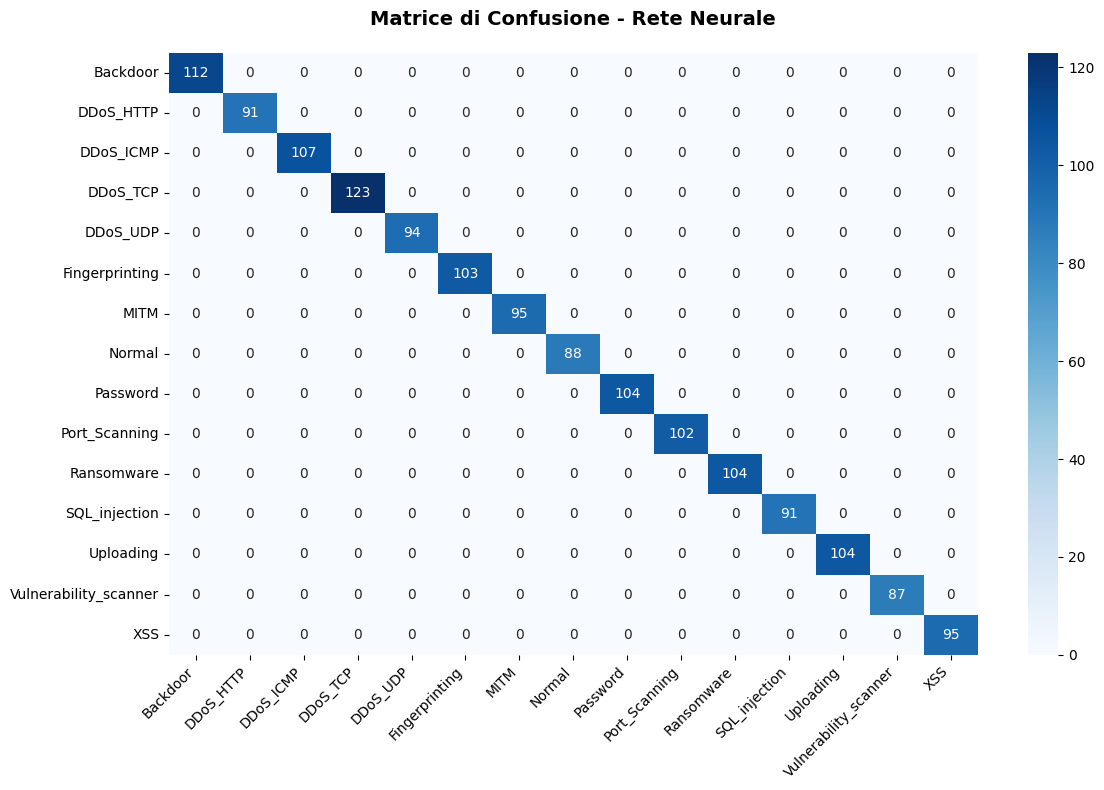

In [ ]:

print(f'Best config: {best_config}')
print(f'Best Validation Accuracy: {best_val_accuracy:.4f}')

# Valutazione finale sul TEST set (solo ora, con il modello già scelto)
y_pred_nn, y_true_nn = test_model(best_nn_model, test_dataloader, device)
acc_nn = accuracy_score(y_true_nn, y_pred_nn)
print(f'\nTest Accuracy (Rete Neurale): {acc_nn:.4f}')

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_true_nn, y_pred_nn, target_names=le_target.classes_))

# Matrice di confusione
cm_nn = confusion_matrix(y_true_nn, y_pred_nn)
labels = le_target.classes_

plt.figure(figsize=(12, 8))
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels,
            yticklabels=labels)
plt.title('Matrice di Confusione - Rete Neurale', 
          fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()